## Updated Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
##Import base libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from PIL import Image
import seaborn as sns
import warnings
import itertools
import random
import scipy.stats as stats

## Early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
84634,00020830_001.png,No Finding,1,20830,31,M,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00020830_001.png
63434,00015647_044.png,Effusion|Infiltration|Pleural_Thickening,44,15647,45,F,AP,3056,2544,0.139,0.139,NaN,/data/images_007/images/00015647_044.png
2814,00000745_002.png,No Finding,2,745,80,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000745_002.png


In [3]:
## Here one may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# List of all NIH disease labels (use exact names as in the dataset)
diseases = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Create a binary column for each disease
for disease in diseases:
    all_xray_df[disease] = all_xray_df['Finding Labels'].str.contains(disease, case=False, na=False).astype(int)

# Show the first few rows with new columns
display(all_xray_df[['Finding Labels'] + diseases].head())

,Finding Labels,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,Cardiomegaly,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Cardiomegaly|Emphysema,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,Cardiomegaly|Effusion,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,No Finding,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
## Here create a new column called 'pneumonia_class' that will allow one to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].str.contains('Pneumonia', case=False, na=False).astype(int)

# Show value counts for check
print(all_xray_df['pneumonia_class'].value_counts())

0    110689
1      1431
Name: pneumonia_class, dtype: int64


## Create training and testing data:

In [5]:
from sklearn.model_selection import train_test_split

def create_splits(df, test_size=0.2, random_state=42):
    """
    Splits the dataframe into training and validation sets, stratified by pneumonia_class.
    """
    train_data, val_data = train_test_split(
        df,
        test_size=test_size,
        stratify=df['pneumonia_class'],
        random_state=random_state
    )
    return train_data, val_data

# Example usage:
train_data, val_data = create_splits(all_xray_df)
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")

Train size: 89696, Validation size: 22424


## Begin model-building & training

#### First suggestion: perform some image augmentation on training data and rescaling the validation data

In [6]:
def my_image_augmentation(is_train=True):
    """
    Returns an ImageDataGenerator with appropriate augmentations.
    For training, use more augmentation; for validation, just rescale.
    """
    if is_train:
        my_idg = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.01,
            zoom_range=0.1,
            fill_mode='nearest'
            # Do NOT use horizontal_flip for chest X-rays!
        )
    else:
        my_idg = ImageDataGenerator(rescale=1./255)
    return my_idg

def make_train_gen(train_df, batch_size=32, target_size=(224,224)):
    train_idg = my_image_augmentation(is_train=True)
    train_gen = train_idg.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=True
    )
    return train_gen

def make_val_gen(val_df, batch_size=32, target_size=(224,224)):
    val_idg = my_image_augmentation(is_train=False)
    val_gen = val_idg.flow_from_dataframe(
        dataframe=val_df,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False
    )
    return val_gen




In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
#valX, valY = val_gen.next()

# Convert pneumonia_class to string for both train and validation sets
# Safely convert pneumonia_class to string using .loc

train_data = train_data.copy()
val_data = val_data.copy()
train_data.loc[:, 'pneumonia_class'] = train_data['pneumonia_class'].astype(str)
val_data.loc[:, 'pneumonia_class'] = val_data['pneumonia_class'].astype(str)

# First, create the validation generator using your function and validation dataframe
val_gen = make_val_gen(val_data)

# Now you can get a batch of validation data
valX, valY = next(val_gen)

print("Validation batch shape:", valX.shape, valY.shape)

Found 22424 validated image filenames belonging to 2 classes.
Validation batch shape: (32, 224, 224, 3) (32,)


Found 89696 validated image filenames belonging to 2 classes.


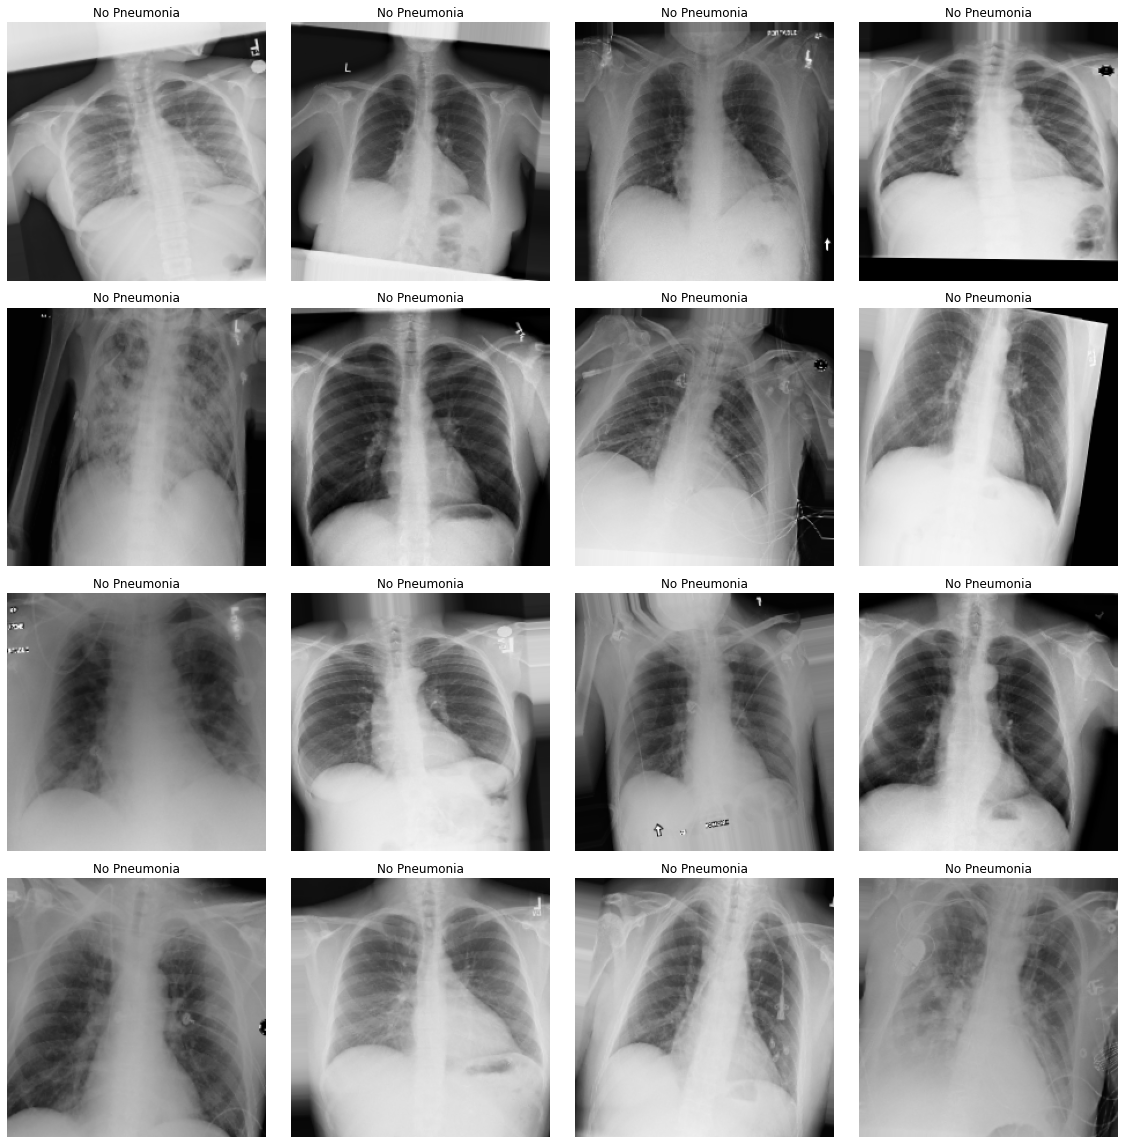

In [8]:
## Look at some examples of augmented training data. 

# Make sure to have created train_gen first:
train_gen = make_train_gen(train_data)

# Get batch of augmented images and labels
t_x, t_y = next(train_gen)

# Plot a 4x4 grid of augmented images
fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    # If images are RGB, use c_x for imshow; if grayscale, use c_x[:,:,0]. 
    if c_x.shape[-1] == 1:
        c_ax.imshow(c_x[:, :, 0], cmap='bone')
    else:
        c_ax.imshow(c_x)
    c_ax.set_title('Pneumonia' if int(float(c_y)) == 1 else 'No Pneumonia')
    c_ax.axis('off')
plt.tight_layout()
plt.show()

Found 1145 validated image filenames.


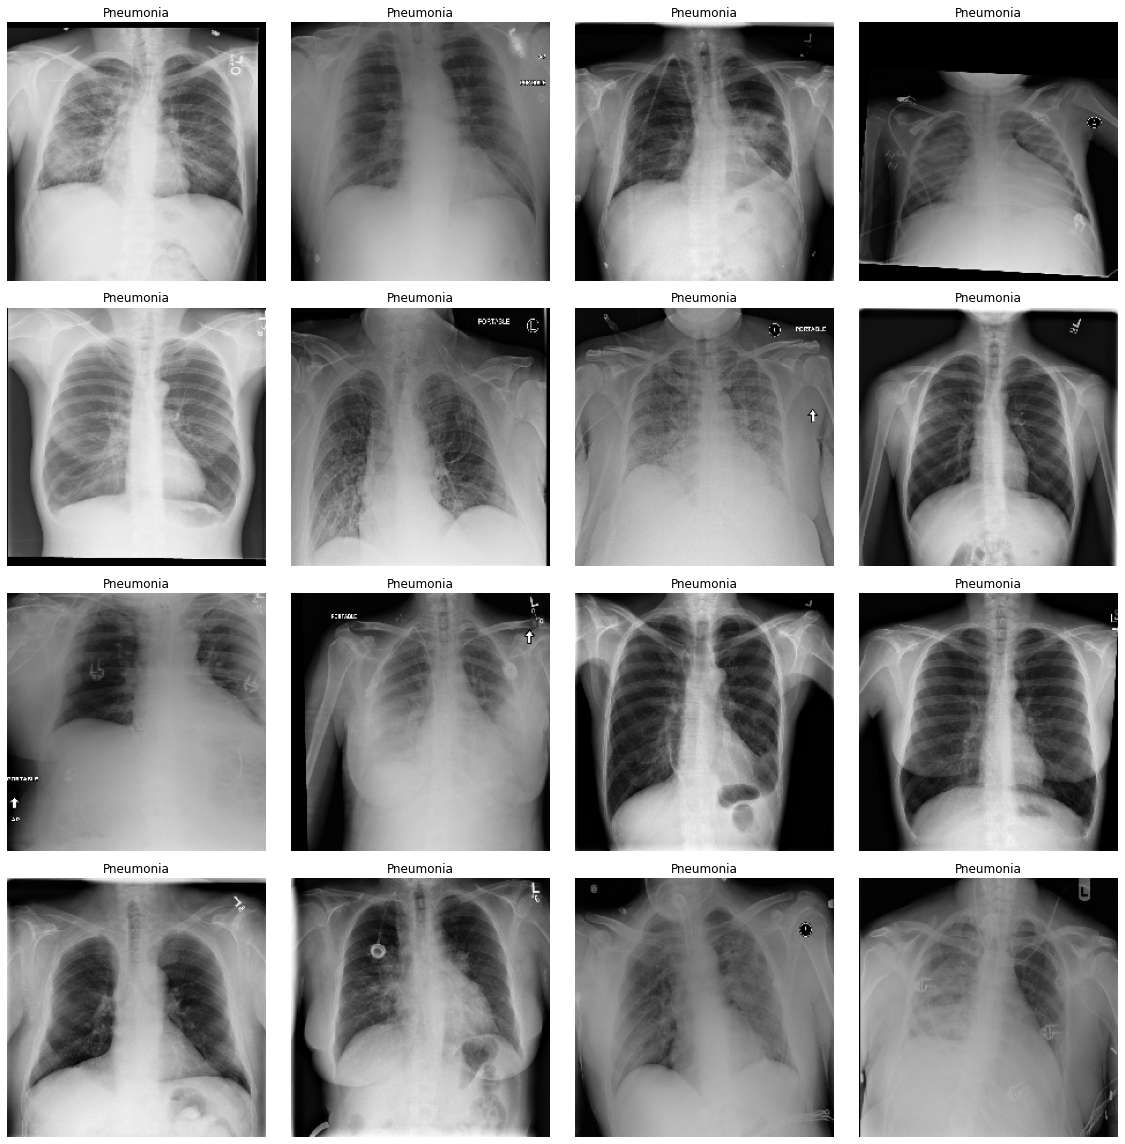

In [9]:
#Since pneumonia is small percent of cases, will visualize examples here. 
pneumonia_only = train_data[train_data['pneumonia_class'] == '1']
pneumonia_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=pneumonia_only,
    x_col='path',
    y_col='pneumonia_class',
    class_mode='raw',  # Use 'raw' for single-class visualization
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)
t_x, t_y = next(pneumonia_gen)

# Get a batch from the pneumonia-only generator
t_x, t_y = next(pneumonia_gen)

fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    if c_x.shape[-1] == 1:
        c_ax.imshow(c_x[:, :, 0], cmap='bone')
    else:
        c_ax.imshow(c_x)
    c_ax.set_title('Pneumonia')
    c_ax.axis('off')
plt.tight_layout()
plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
#Import base VGG16 mod
from tensorflow.keras.applications import VGG16

def load_pretrained_model(input_shape=(224, 224, 3)):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    return base_model


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_my_model_with_cam(input_shape=(224, 224, 3)):
    base_model = load_pretrained_model(input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name='classification')(x)

    # For CAM, pick the last convolutional layer (e.g., 'block5_conv3' in VGG16)
    cam_layer = base_model.get_layer('block5_conv3').output

    # Model with two outputs: classification and CAM layer
    model = Model(inputs=base_model.input, outputs=[output, cam_layer])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss={'classification': 'binary_crossentropy'},
        metrics={'classification': ['accuracy', tf.keras.metrics.AUC(name='auc')]}
    )
    return model

# Usage:
my_model = build_my_model_with_cam()
my_model.summary()


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

weight_path = "xray_class_my_model.best.hdf5"

# Updated to use val_auc instead of val_classification_auc
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_auc',    # Changed from val_classification_auc
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

early = EarlyStopping(
    monitor='val_auc',    # Changed from val_classification_auc
    mode='max',
    patience=10,
    verbose=1
)

callbacks_list = [checkpoint, early]
print(callbacks_list)

[<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7e266296e3d0>, <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7e266296e390>]


### Start training! 

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

def build_my_model(input_shape=(224, 224, 3)):
    base_model = load_pretrained_model(input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name='classification')(x)

    # Model with only the classification output
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

my_model = build_my_model(input_shape=(224, 224, 3))
my_model.summary()

# For CAM visualization after training:
cam_model = Model(inputs=my_model.input, outputs=[
    my_model.output,
    my_model.get_layer('block5_conv3').output
])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [30]:
# Assuming train_gen, val_gen, and callbacks_list are already defined

#from workspace_utils import active_session

# Here is the full CNN Training code, because this expires often, am using a smaller sample for code verification.
#train_gen = make_train_gen(train_data)
#val_gen = make_val_gen(val_data)

#history = my_model.fit(
 #   train_gen,
 #   validation_data=val_gen,
 #   epochs=10,
 #   callbacks=callbacks_list
#)

#Create a small sample to verify training code given limitations with GPU workspace. 
# 1. Create balanced dataset samples
test_train_data = pd.concat([
    train_data[train_data['pneumonia_class'] == '0'].sample(n=800, random_state=42),
    train_data[train_data['pneumonia_class'] == '1'].sample(n=200, random_state=42)
])

test_val_data = pd.concat([
    val_data[val_data['pneumonia_class'] == '0'].sample(n=160, random_state=42),
    val_data[val_data['pneumonia_class'] == '1'].sample(n=40, random_state=42)
])

# 2. Create generators with smaller batch size
train_gen = make_train_gen(test_train_data, batch_size=16)
val_gen = make_val_gen(test_val_data, batch_size=16)

# 3. Quick training run
history = my_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    callbacks=callbacks_list,
    workers=1,
    max_queue_size=2
)

Found 1000 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 13 steps
62/63 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.7937 - auc: 0.6188
Epoch 00001: val_auc improved from 0.57047 to 0.57430, saving model to xray_class_my_model.best.hdf5
63/63 [==============================] - 28s 448ms/step - loss: 0.4900 - accuracy: 0.7960 - auc: 0.6214 - val_loss: 0.5361 - val_accuracy: 0.8000 - val_auc: 0.5743


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

Found 16 validated image filenames belonging to 2 classes.
16/16 [==============================] - 0s 7ms/sample


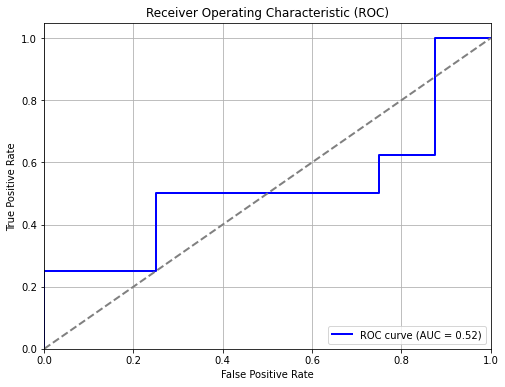

AUC: 0.5156
Best threshold: 0.10
F1 score: 0.6957
Precision: 0.5333
Recall: 1.0000


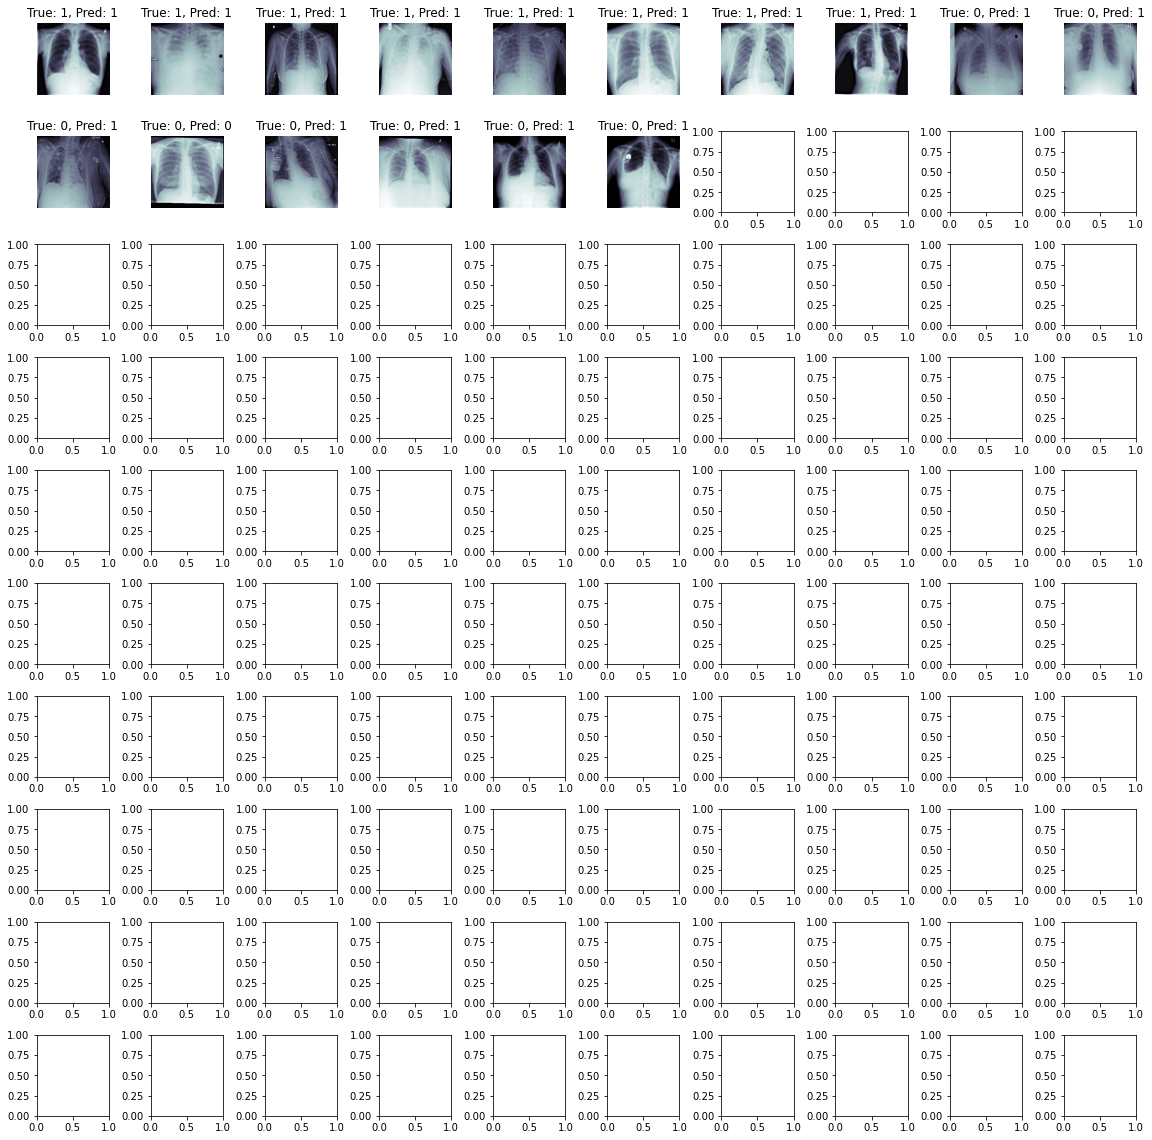


Class distribution in validation set:
0.0    8
1.0    8
dtype: int64


In [38]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

# 1. Create balanced validation set for predictions of a limited sample of images.
val_balanced = pd.concat([
    val_data[val_data['pneumonia_class'] == '1'].sample(n=8, random_state=42),  # Positive cases
    val_data[val_data['pneumonia_class'] == '0'].sample(n=8, random_state=42)   # Negative cases
])

# 2. Create generator with balanced data
val_gen_balanced = make_val_gen(val_balanced, batch_size=16)

# 3. Make predictions on balanced set
my_model.load_weights(weight_path)
valX, valY = next(val_gen_balanced)  # This will now have both classes
pred_Y = my_model.predict(valX, batch_size=16, verbose=True)

# 4. Evaluate and visualize
plot_auc(valY, pred_Y)
best_thresh = find_best_threshold(valY, pred_Y)
binary_pred_Y = (pred_Y > best_thresh).astype(int)
plot_true_vs_pred(valX, valY, pred_Y, best_thresh, n=16)

# 5. Print class distribution to verify
print("\nClass distribution in validation set:")
print(pd.Series(valY).value_counts())



Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Optimal Threshold Analysis:
Best threshold: 0.10
At this threshold:
F1 score:   0.6957
Precision:  0.5333
Recall:     1.0000
Accuracy:   0.5625
AUC-ROC:    0.5156


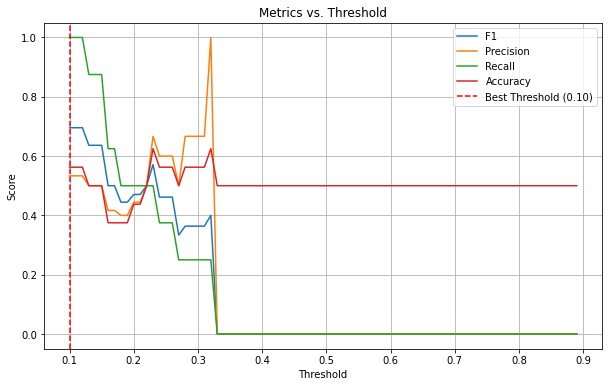

In [44]:
## Find the threshold that optimizes your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

def find_best_threshold(y_true, y_pred_probs):
    """
    Finds optimal threshold by evaluating multiple metrics.
    Returns the best threshold and prints comprehensive metrics.
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    metrics = {
        'f1': [],
        'precision': [],
        'recall': [],
        'accuracy': [],
        'threshold': thresholds
    }
    
    # Calculate metrics for each threshold
    for thresh in thresholds:
        y_pred = (y_pred_probs > thresh).astype(int)
        metrics['f1'].append(f1_score(y_true, y_pred))
        metrics['precision'].append(precision_score(y_true, y_pred))
        metrics['recall'].append(recall_score(y_true, y_pred))
        metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    
    # Find best threshold for F1 score (primary metric)
    best_idx = np.argmax(metrics['f1'])
    best_threshold = thresholds[best_idx]
    
    # Print comprehensive results
    print("\nOptimal Threshold Analysis:")
    print(f"Best threshold: {best_threshold:.2f}")
    print(f"At this threshold:")
    print(f"F1 score:   {metrics['f1'][best_idx]:.4f}")
    print(f"Precision:  {metrics['precision'][best_idx]:.4f}")
    print(f"Recall:     {metrics['recall'][best_idx]:.4f}")
    print(f"Accuracy:   {metrics['accuracy'][best_idx]:.4f}")
    print(f"AUC-ROC:    {roc_auc_score(y_true, y_pred_probs):.4f}")
    
    # Plot metrics vs thresholds
    plt.figure(figsize=(10, 6))
    for metric in ['f1', 'precision', 'recall', 'accuracy']:
        plt.plot(thresholds, metrics[metric], label=metric.capitalize())
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Metrics vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_threshold

# Usage with balanced validation set:
best_thresh = find_best_threshold(valY, pred_Y)
binary_pred_Y = (pred_Y > best_thresh).astype(int)

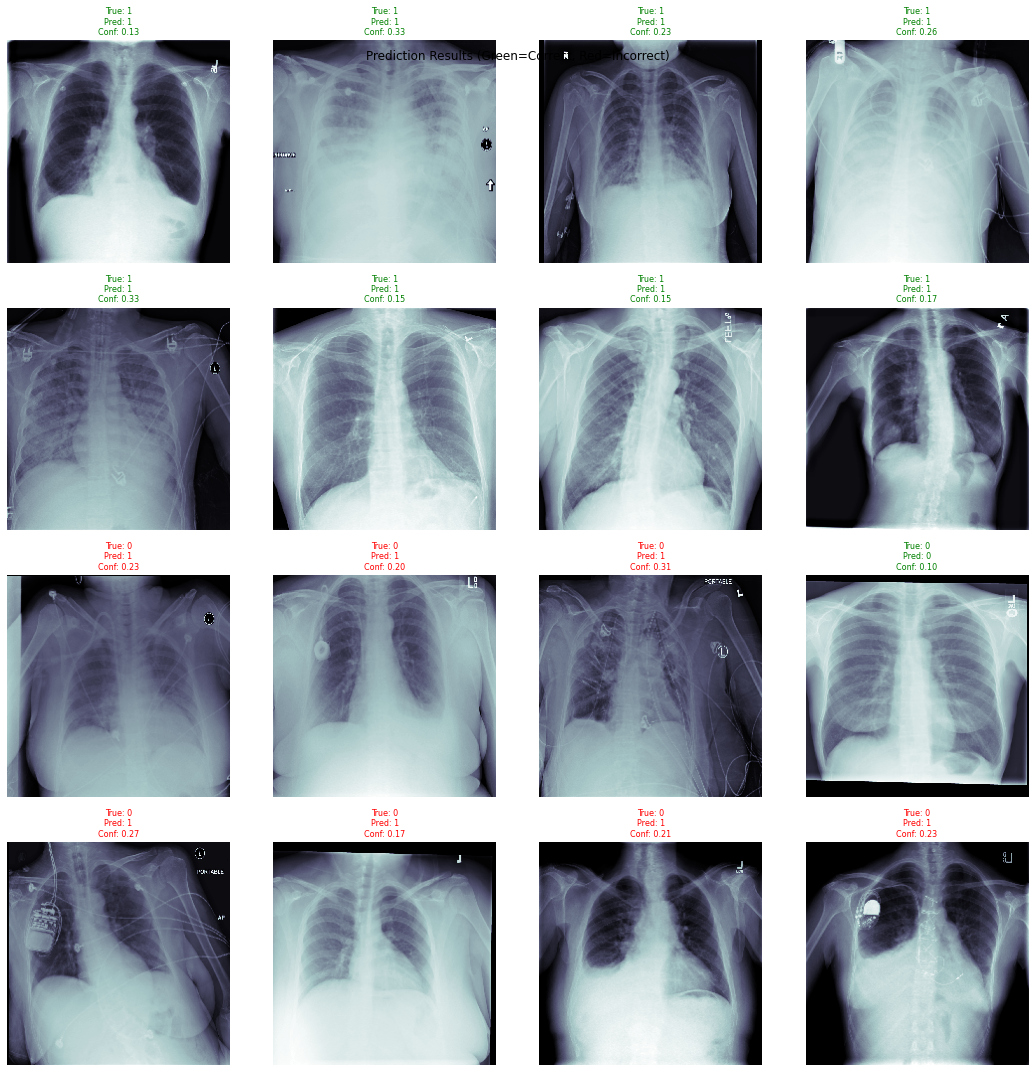


Prediction Summary for 16 samples:
Accuracy: 800.00%
Correct predictions: 128/16


In [45]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

## Let's look at some examples of true vs. predicted with our best model: 

def plot_true_vs_pred(valX, valY, pred_Y, threshold, n=16):
    """
    Enhanced visualization of model predictions with confidence scores.
    
    Args:
        valX: validation images (numpy array)
        valY: true labels (numpy array)
        pred_Y: predicted probabilities (numpy array)
        threshold: classification threshold
        n: number of examples to plot (default 16)
    """
    # Calculate predictions and probabilities
    binary_pred_Y = (pred_Y > threshold).astype(int)
    
    # Determine grid size (default 4x4)
    grid_size = int(np.ceil(np.sqrt(n)))
    fig, m_axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    # Create color map for predictions
    colors = {
        (0,0): 'green',  # True Negative
        (0,1): 'red',    # False Positive
        (1,0): 'red',    # False Negative
        (1,1): 'green'   # True Positive
    }
    
    for idx, (img, true_label, pred_label, prob, ax) in enumerate(
            zip(valX[:n], valY[:n], binary_pred_Y[:n], pred_Y[:n], m_axs.flatten())):
        
        if idx < n:
            # Display image
            ax.imshow(img[:,:,0], cmap='bone')
            
            # Set title color based on prediction correctness
            color = colors[(int(true_label), int(pred_label))]
            
            # Create detailed title with prediction confidence
            title = f'True: {int(true_label)}\nPred: {int(pred_label)}\nConf: {prob[0]:.2f}'
            ax.set_title(title, color=color, fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle('Prediction Results (Green=Correct, Red=Incorrect)', y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    correct = np.sum(binary_pred_Y[:n] == valY[:n])
    print(f"\nPrediction Summary for {n} samples:")
    print(f"Accuracy: {correct/n:.2%}")
    print(f"Correct predictions: {correct}/{n}")

# Example usage:
plot_true_vs_pred(valX, valY, pred_Y, best_thresh, n=16)



In [46]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved to my_model_architecture.json")

Model architecture saved to my_model_architecture.json


In [47]:
import os
print("\nModel Files Status:")
print(f"Architecture file exists: {os.path.exists('my_model_architecture.json')}")
print(f"Weights file exists: {os.path.exists('xray_class_my_model.best.hdf5')}")


Model Files Status:
Architecture file exists: True
Weights file exists: True
